# **Step 1: Import data and necessary libraries**

In [1]:
# Mount Drive
from google.colab import drive

drive.mount('/content/drive')

# Install required libraries if needed
!pip install astropy

# Imports
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.transform import resize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.metrics import silhouette_score
from scipy import ndimage

warnings.filterwarnings('ignore')

Mounted at /content/drive


# **Step 2: Define paths**

In [19]:
# Paths to dataset directory and results directory
data_path = "/content/drive/My Drive/continuum_data_subset"
output_path = "/content/drive/My Drive/clustering_results"
os.makedirs(output_path, exist_ok=True)

In [3]:
# List all files to confirm access
os.listdir(data_path)

['planet0_00226_1250.fits',
 'planet100_00580_1250.fits',
 'planet10_00710_1250.fits',
 'planet10_00816_1250.fits',
 'planet1_00490_1250.fits',
 'planet101_00972_1250.fits',
 'planet101_00988_1250.fits',
 'planet102_00142_1250.fits',
 'planet102_00188_1250.fits',
 'planet102_00222_1250.fits',
 'planet102_00230_1250.fits',
 'planet102_00346_1250.fits',
 'planet103_00510_1250.fits',
 'planet103_00718_1250.fits',
 'planet11_00010_1250.fits',
 'planet11_00700_1250.fits',
 'planet11_00886_1250.fits',
 'planet13_00098_1250.fits',
 'planet13_00302_1250.fits',
 'planet13_00324_1250.fits',
 'planet14_00314_1250.fits',
 'planet14_00528_1250.fits',
 'planet14_00804_1250.fits',
 'planet14_00914_1250.fits',
 'planet15_00186_1250.fits',
 'planet16_00614_1250.fits',
 'planet17_00162_1250.fits',
 'planet17_00506_1250.fits',
 'planet17_00648_1250.fits',
 'planet18_00114_1250.fits',
 'planet18_00942_1250.fits',
 'planet18_00992_1250.fits',
 'planet19_00914_1250.fits',
 'planet20_00230_1250.fits',
 'plan

# **Step 3: Visualizing a sample image**

Original data shape: (4, 1, 1, 600, 600)
Processed image shape: (600, 600)


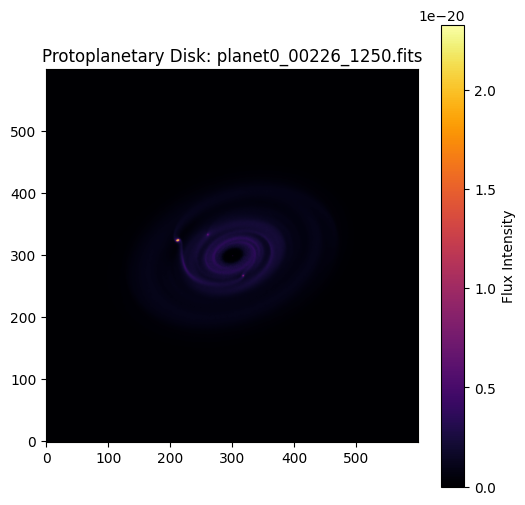

In [4]:
# Define path to the .fits files
drive_path = "/content/drive/My Drive/continuum_data_subset"
fits_files = [f for f in os.listdir(drive_path) if f.endswith('.fits')]

# Load the first .fits file
fits_path = os.path.join(drive_path, fits_files[0])

with fits.open(fits_path) as hdul:
    data = hdul[0].data

# Check the shape of the loaded data
print(f"Original data shape: {data.shape}")

# Extract the correct image slice
image = data[0, 0, 0, :, :]

print(f"Processed image shape: {image.shape}")

# Display the image
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='inferno', origin='lower')
plt.colorbar(label="Flux Intensity")
plt.title(f"Protoplanetary Disk: {fits_files[0]}")
plt.show()

# **Step 4: Implementation of Clustering algorithms**

## **1. K-Means Clustering**

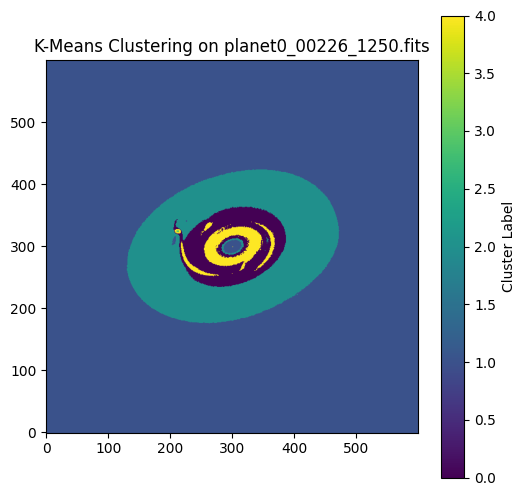

In [5]:
# Flatten the image for clustering
image_flattened = image.reshape(-1, 1)  # Convert to 1D array

# Standardize the data (important for clustering)
scaler = StandardScaler()
image_flattened_scaled = scaler.fit_transform(image_flattened)

# Apply K-Means clustering
n_clusters = 5  # Adjust based on visual results
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(image_flattened_scaled)

# Reshape labels back into image dimensions
clustered_image = labels.reshape(image.shape)

# Visualize the clustering result
plt.figure(figsize=(6,6))
plt.imshow(clustered_image, cmap='viridis', origin='lower')
plt.colorbar(label="Cluster Label")
plt.title(f"K-Means Clustering on {fits_files[0]}")
plt.show()

## **2. PCA + K-Means**

**Note**: We apply PCA in the next section to reduce dimensionality and partially mitigate biases introduced by viewing angle variations in disk observations.

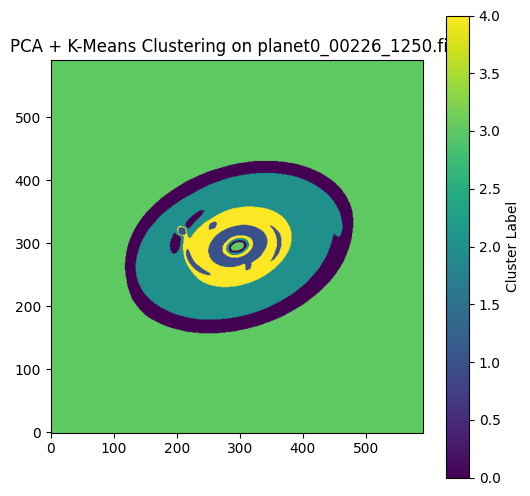

In [6]:
# Extract small 10x10 patches from the image
patch_size = (10, 10)
patches = extract_patches_2d(image, patch_size)
patches = patches.reshape(patches.shape[0], -1)  # Flatten each patch

# Standardize the patches
scaler = StandardScaler()
patches_scaled = scaler.fit_transform(patches)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2D features
patches_pca = pca.fit_transform(patches_scaled)

# Reshape back to image dimensions
cluster_input = patches_pca[:, 0].reshape(image.shape[0] - patch_size[0] + 1, image.shape[1] - patch_size[1] + 1)

# Apply K-Means on PCA-transformed data
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(cluster_input.reshape(-1, 1))

# Reshape labels to match the image
clustered_image = labels.reshape(cluster_input.shape)

# Visualize clustering results
plt.figure(figsize=(6,6))
plt.imshow(clustered_image, cmap='viridis', origin='lower')
plt.colorbar(label="Cluster Label")
plt.title(f"PCA + K-Means Clustering on {fits_files[0]}")
plt.show()

## **3. GMM**

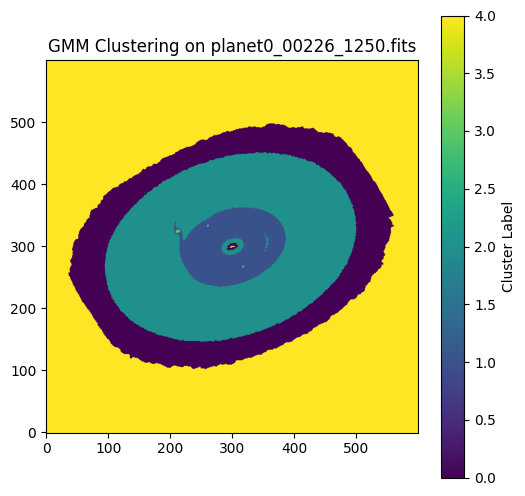

In [7]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5, random_state=42)
labels = gmm.fit_predict(image_flattened_scaled)
clustered_image = labels.reshape(image.shape)

plt.figure(figsize=(6,6))
plt.imshow(clustered_image, cmap='viridis', origin='lower')
plt.colorbar(label="Cluster Label")
plt.title(f"GMM Clustering on {fits_files[0]}")
plt.show()

## **4. HDBScan**

In [8]:
!pip install hdbscan

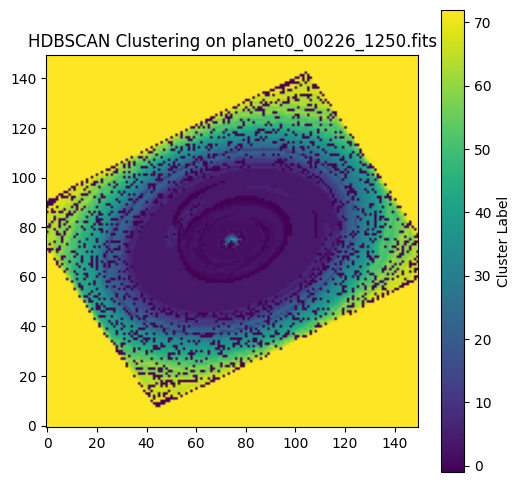

In [9]:
import cv2
import hdbscan
from skimage.transform import rotate

# Step 2: Handle Inf & NaN Values (Fix the Crash)
image = np.nan_to_num(image, nan=np.nanmedian(image))  # Replace NaNs with median
image[~np.isfinite(image)] = np.max(image[np.isfinite(image)])  # Replace Infs with max finite value

# Step 3: Clip Extreme Values (Fixes Overflows)
image = np.clip(image, np.percentile(image, 1), np.percentile(image, 99))  # Remove extreme outliers

# Step 4: Downsample the Image for Efficiency
downsampled_image = cv2.resize(image, (150, 150), interpolation=cv2.INTER_AREA)

# Flatten and Scale the Image
image_flattened = downsampled_image.reshape(-1, 1)
scaler = StandardScaler()
image_scaled = scaler.fit_transform(image_flattened)  # NOW this should work

# Step 5: Apply HDBSCAN Clustering
hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=20)
labels = hdb.fit_predict(image_scaled)

# Step 6: Reshape Labels and Plot the Clustered Image
clustered_image = labels.reshape(downsampled_image.shape)
# clustered_image = rotate(clustered_image, angle=, mode='edge')  # Adjust angle if needed

plt.figure(figsize=(6,6))
plt.imshow(clustered_image, cmap='viridis', origin='lower')
plt.colorbar(label="Cluster Label")
plt.title(f"HDBSCAN Clustering on {fits_files[0]}")
plt.show()

## **✅ Final Chosen Model: Improved KMeans Clustering**
This method produced the most consistent and accurate visual clusters across the dataset. It preserves structure, reveals spiral arms and rings clearly, and is computationally efficient.

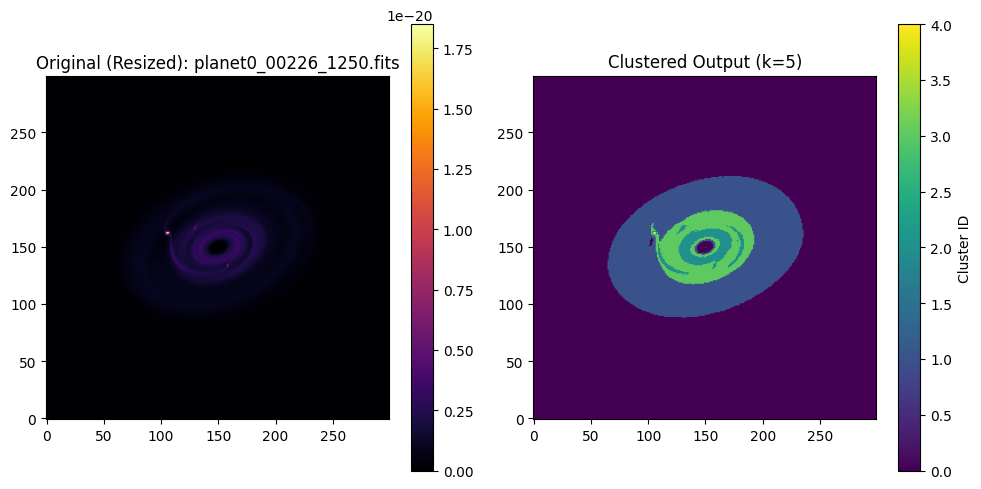

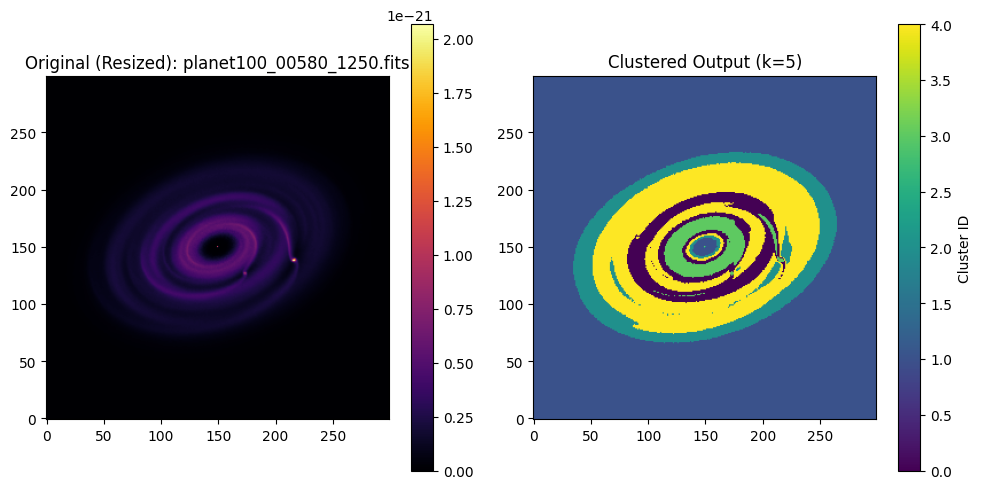

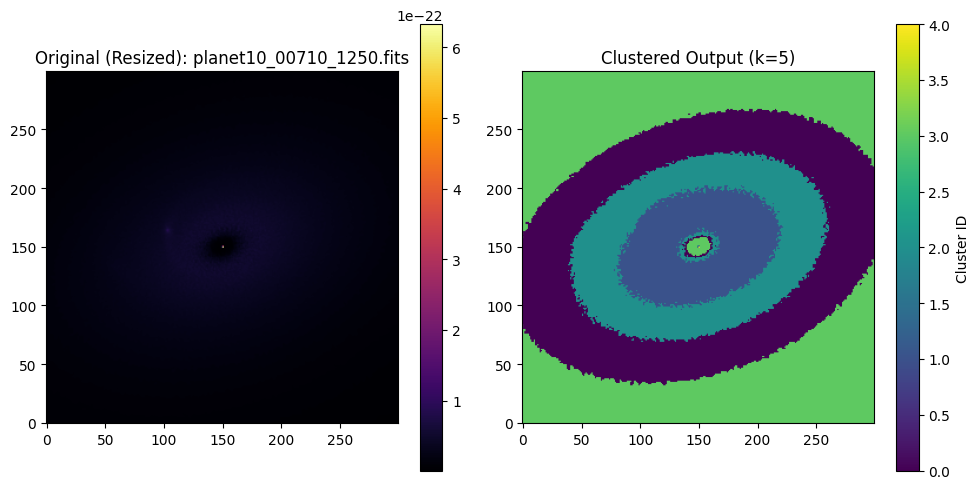

In [15]:
drive_path = "/content/drive/My Drive/continuum_data_subset"
fits_files = [f for f in os.listdir(drive_path) if f.endswith('.fits')]
fits_files = fits_files[:3]  # Limit for speed

n_clusters = 5

def process_fits_file(file_name):
    fits_path = os.path.join(drive_path, file_name)
    with fits.open(fits_path) as hdul:
        data = hdul[0].data
    image = data[0, 0, 0, :, :]
    return image

# Loop through files
for idx, file_name in enumerate(fits_files):
    image = process_fits_file(file_name)

    # Resize to 300x300 for balance between speed & detail
    image_resized = resize(image, (300, 300), anti_aliasing=True)

    # Flatten + scale
    image_flat = image_resized.reshape(-1, 1)
    scaler = StandardScaler()
    image_scaled = scaler.fit_transform(image_flat)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=5)
    labels = kmeans.fit_predict(image_scaled)
    clustered_image = labels.reshape(image_resized.shape)

    # Show result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_resized, cmap='inferno', origin='lower')
    plt.title(f"Original (Resized): {file_name}")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(clustered_image, cmap='viridis', origin='lower')
    plt.title(f"Clustered Output (k={n_clusters})")
    plt.colorbar(label="Cluster ID")
    plt.tight_layout()
    plt.show()

In [23]:
# Saving the model to a drive directory
# Define paths
drive_path = "/content/drive/My Drive/continuum_data_subset"
output_path_kmeans = "/content/drive/My Drive/clustering_kmeans_raw"
os.makedirs(output_path_kmeans, exist_ok=True)

# Grab fits files
fits_files = [f for f in os.listdir(drive_path) if f.endswith('.fits')]

n_clusters = 5

def process_fits_file(file_name):
    fits_path = os.path.join(drive_path, file_name)
    with fits.open(fits_path) as hdul:
        data = hdul[0].data
    image = data[0, 0, 0, :, :]  # First slice only
    return image

# Loop + process + save
for idx, file_name in enumerate(fits_files):
    try:
        image = process_fits_file(file_name)
        image_resized = resize(image, (300, 300), anti_aliasing=True)

        # Flatten + scale
        image_flat = image_resized.reshape(-1, 1)
        scaler = StandardScaler()
        image_scaled = scaler.fit_transform(image_flat)

        # KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(image_scaled)
        clustered_image = labels.reshape(image_resized.shape)

        # Plot & Save
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        axs[0].imshow(image_resized, cmap='inferno', origin='lower')
        axs[0].set_title(f"Original (Resized): {file_name}")
        axs[0].axis('off')

        im = axs[1].imshow(clustered_image, cmap='viridis', origin='lower')
        axs[1].set_title(f"Clustered Output (k={n_clusters})")
        axs[1].axis('off')

        plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04, label="Cluster ID")
        plt.suptitle(f"Clustering on {file_name}", fontsize=14)
        plt.tight_layout()

        save_path = os.path.join(output_path_kmeans, f"{file_name}_kmeans.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)

    except Exception as e:
        print(f"⚠️ Skipping {file_name} due to error: {e}")

print("✅ All Improved KMeans cluster outputs saved to 'clustering_kmeans_raw'")

✅ All Improved KMeans cluster outputs saved to 'clustering_kmeans_raw'


In [24]:
import joblib
joblib.dump(kmeans, 'improved_kmeans_model.pkl')

['improved_kmeans_model.pkl']

# **🧪 Exploratory Pipeline: Choosing best n_clusters and labeling the clustered images (Not Final)**
This pipeline was an exploration into feature-engineered clustering. While promising in some cases, it was ultimately outperformed by direct pixel-based KMeans. Included here for completeness.

## **Function to auto-choose best n_clusters**


In [16]:
def find_best_k_for_image(patches_pca, k_min=2, k_max=10):
    best_k = k_min
    best_score = -1

    for k in range(k_min, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(patches_pca)

        # Evaluate silhouette
        score = silhouette_score(patches_pca, labels)

        if score > best_score:
            best_score = score
            best_k = k

    return best_k, best_score

## **Function to overlay text labels on clustered_image**

In [17]:
def label_clusters(ax, clustered_image):
    """
    Overlays cluster IDs on top of the segmented image.
    ax: matplotlib axes
    clustered_image: 2D array of integer labels
    """
    unique_labels = np.unique(clustered_image)
    for lab in unique_labels:
        coords = np.argwhere(clustered_image == lab)
        if coords.size > 0:
            # centroid of all pixels in this cluster
            cy, cx = coords.mean(axis=0)  # y, x
            ax.text(
                x=cx, y=cy,
                s=str(lab),
                color='white', fontsize=12, fontweight='bold',
                ha='center', va='center'
            )

## **Data Preprocessing**

In [18]:
def process_fits(file_path, patch_size=(10, 10), n_clusters=5, auto_choose_k=False):
    """
    Given a path to a .fits file, loads the image,
    extracts patches, applies PCA and K-Means, and
    returns the original + clustered image arrays.

    Parameters
    ----------
    file_path : str
        Path to the FITS file
    patch_size : (int, int)
        Size of the extracted patches
    n_clusters : int
        Number of clusters (used if auto_choose_k=False)
    auto_choose_k : bool
        Whether to auto-tune n_clusters using silhouette analysis
    """

    # 1. Open FITS file
    with fits.open(file_path) as hdul:
        data = hdul[0].data
        print(f"\n[DEBUG] {file_path} -> data.shape = {data.shape}")

    # 2. Attempt to slice data in a flexible way.
    image = None
    try:
        # Try the 5D slice if shape is (4,1,1,600,600)
        image = data[0, 0, 0, :, :]
        print(f"[DEBUG] Using data[0,0,0,:,:]. shape={image.shape}")
    except:
        pass

    if image is None or len(image.shape) != 2:
        try:
            # Try the 3D slice if shape is (4,600,600)
            image = data[0, :, :]
            print(f"[DEBUG] Using data[0,:,:]. shape={image.shape}")
        except:
            pass

    # If still None, try the simplest approach
    if image is None or len(image.shape) != 2:
        try:
            # Perhaps it is already 2D?
            image = data
            print(f"[DEBUG] Using data as-is. shape={image.shape}")
        except:
            pass

    # If we STILL have no valid image, raise an error
    if image is None or len(image.shape) != 2:
        raise ValueError("Could not find a valid 2D slice in the FITS file.")

    # 3. Check for non-finite values
    if not np.isfinite(image).all():
        raise ValueError("Non-finite values (inf/nan) detected.")

    # 4. Check variance
    var_val = np.var(image)
    print(f"[DEBUG] variance of selected slice: {var_val}")

    # 5. Extract patches
    patches = extract_patches_2d(image, patch_size)
    patches = patches.reshape(patches.shape[0], -1)

    # 6. Standardize
    scaler = StandardScaler()
    patches_scaled = scaler.fit_transform(patches)

    # 7. PCA
    pca = PCA(n_components=min(10, patches_scaled.shape[1]))
    patches_pca = pca.fit_transform(patches_scaled)

    # Automatic best k
    if auto_choose_k:
        best_k, best_score = find_best_k_for_image(patches_pca, k_min=2, k_max=10)
        print(f"[DEBUG] Auto-chosen n_clusters={best_k} with silhouette={best_score:.3f}")
        n_clusters = best_k

    # 8. K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(patches_pca)

    # 9. Reshape labels
    grid_shape = (
        image.shape[0] - patch_size[0] + 1,
        image.shape[1] - patch_size[1] + 1
    )
    clustered_image = labels.reshape(grid_shape)

    return image, clustered_image

## **Saving the data clusters to a new directory**

In [20]:
fits_files = [f for f in os.listdir(data_path) if f.endswith('.fits')]

for file in fits_files:
    file_path = os.path.join(data_path, file)
    try:
        original, clustered = process_fits(file_path, patch_size=(10,10), n_clusters=5, auto_choose_k=False)

        # Plot & save
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Original
        axs[0].imshow(original, cmap='inferno', origin='lower')
        axs[0].set_title('Original Image')
        axs[0].axis('off')

        # Clustered
        im = axs[1].imshow(clustered, cmap='viridis', origin='lower')
        axs[1].set_title('Clustered Image')
        axs[1].axis('off')

        # Overlay text cluster IDs:
        plt.suptitle(f'Clustering on {file}')
        plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04, label='Cluster ID')
        plt.tight_layout()

        plt.savefig(os.path.join(output_path, f'{file}_clustered.png'))
        plt.close(fig)

    except Exception as e:
        print(f"⚠️ Skipping {file} due to error: {e}")

print("\n✅ All valid images processed and saved.")


[DEBUG] /content/drive/My Drive/continuum_data_subset/planet0_00226_1250.fits -> data.shape = (4, 1, 1, 600, 600)
[DEBUG] Using data[0,0,0,:,:]. shape=(600, 600)
[DEBUG] variance of selected slice: 2.788583944006386e-43

[DEBUG] /content/drive/My Drive/continuum_data_subset/planet100_00580_1250.fits -> data.shape = (4, 1, 1, 600, 600)
[DEBUG] Using data[0,0,0,:,:]. shape=(600, 600)
[DEBUG] variance of selected slice: 1.401298464324817e-44

[DEBUG] /content/drive/My Drive/continuum_data_subset/planet10_00710_1250.fits -> data.shape = (4, 1, 1, 600, 600)
[DEBUG] Using data[0,0,0,:,:]. shape=(600, 600)
[DEBUG] variance of selected slice: 0.0

[DEBUG] /content/drive/My Drive/continuum_data_subset/planet10_00816_1250.fits -> data.shape = (4, 1, 1, 600, 600)
[DEBUG] Using data[0,0,0,:,:]. shape=(600, 600)
[DEBUG] variance of selected slice: 0.0

[DEBUG] /content/drive/My Drive/continuum_data_subset/planet1_00490_1250.fits -> data.shape = (4, 1, 1, 600, 600)
[DEBUG] Using data[0,0,0,:,:]. sh

KeyboardInterrupt: 